In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [17]:
# read in data
# already performed ADF test and confirmed data is stationary
cpu_util = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_cpu_utilization_53ea38.csv")
cpu_util.head()

,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706


Anomaly Detection Using ARIMA
- steps:
    - check for stationarity
    - fit time series model to preprocessed data
    - find squared error for each observation
    - find threshold for errors in data
    - find anomalies: compare observed time series values w/ values predicted by ARIMA model. If the difference exceeds some threshold, flag that observation as an anomaly 
- p = number of laged observations
- d = order of differencing
- q = order of the moving avg part 

In [8]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(cpu_util["value"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
cpu_util['val_diff'] = cpu_util['value'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(cpu_util["val_diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -9.8419
p-value (Original): 0.0000
Interpretation: The original series is Stationary.

ADF Statistic (Differenced): -17.2580
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


In [ ]:
''' train time series model
ARIMA's parameters: p and q
p = for autoregression pt of model; how far back in time should we go to predict the current observation
q = for moving avg part of the model; represents num of lagged forecast errors included in the model 
'''
from sklearn.calibration import Parallel, delayed
from statsmodels.tsa.arima.model import ARIMA


max_p, max_q = 5, 5 
def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets
def find_aic_for_model(data, p, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order p, q = {p, q}n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, q)
        ts_results = model(data, order=(p, q)).fit(disp=False)
        curr_aic = ts_results.aic
        return curr_aic, (p, q)
    except Exception as e:
        f"""Exception occurred continuing {e}"""
        return None, (p, q)
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(0, 1)).fit(disp=False)
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(0, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            results = Parallel(n_jobs=len(order_set), prefer='threads')(
                delayed(find_aic_for_model)(data, p, q, model, model_name)
                for q in order_set
            )
            final_results.extend(results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df

print(find_best_order_for_model(cpu_util, ARMA, "ARMA"))
# print(min_aic, min_order)# Output: 1341.1035677173795, (4, 4)




ValueError: `order` argument must be an iterable with three elements.

In [11]:
!pip install prophet


  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/15/9a/a8d35652e869011a3bae9e0888f4c62157bf9067c9be15535602c73039dd/prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/3c/1c/9e3fc8b8d4f2361b423e726732fcbb81f8817c7399a94d25296fc668586a/holidays-0.69-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd

In [18]:
# rename cols to be compatible w/ prophet
cpu_util.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)



In [25]:
from prophet import Prophet

def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
               seasonality_mode = 'additive',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
   print("m: ", m)
   m = m.fit(dataframe)
   forecast = m.predict(dataframe)
   print("forecast: ", forecast)
   forecast['fact'] = dataframe['y'].reset_index(drop = True)
   return forecast

pred = fit_predict_model(cpu_util)

# push pred variable to another function
def detect_anomalies(forecast):
   forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
   forecasted['anomaly'] = 0
   forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
   forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
   forecasted['importance'] = 0
   forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
   forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
   return forecasted

pred = detect_anomalies(pred)

12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing


m:  <prophet.forecaster.Prophet object at 0x175ee4890>
forecast:                        ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2014-02-14 14:30:00  1.818194    1.557410    2.062446     1.818194   
1    2014-02-14 14:35:00  1.818185    1.565164    2.083271     1.818185   
2    2014-02-14 14:40:00  1.818177    1.571440    2.077948     1.818177   
3    2014-02-14 14:45:00  1.818168    1.565267    2.074261     1.818168   
4    2014-02-14 14:50:00  1.818159    1.585787    2.055995     1.818159   
...                  ...       ...         ...         ...          ...   
4027 2014-02-28 14:05:00  1.821644    1.566970    2.070859     1.821644   
4028 2014-02-28 14:10:00  1.821625    1.555357    2.086889     1.821625   
4029 2014-02-28 14:15:00  1.821606    1.565512    2.091153     1.821606   
4030 2014-02-28 14:20:00  1.821587    1.558450    2.096931     1.821587   
4031 2014-02-28 14:25:00  1.821567    1.556938    2.061319     1.821567   

      trend_upper  additive_terms

In [33]:
pred["anomaly"].sum() # got non-zero value, so it was able to flag some observations as anomalies

59

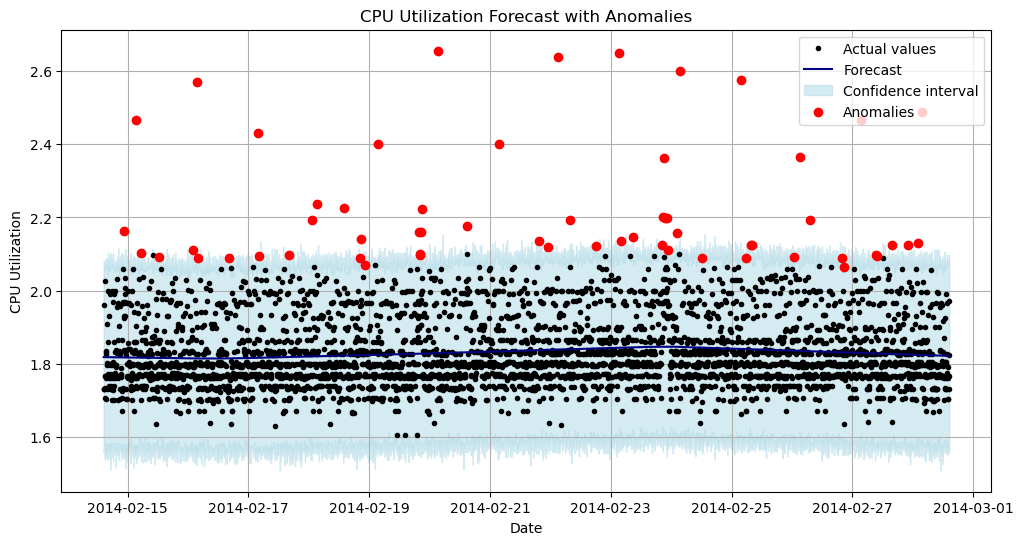

In [26]:
import matplotlib.pyplot as plt

def plot_forecast(pred):
    plt.figure(figsize=(12, 6))
    
    # Plot the actual values
    plt.plot(pred['ds'], pred['fact'], 'k.', label='Actual values')
    
    # Plot the predicted yhat values
    plt.plot(pred['ds'], pred['yhat'], color='navy', label='Forecast')
    
    # Plot upper and lower bounds
    plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='lightblue', alpha=0.5, label='Confidence interval')
    
    # Highlight anomalies
    anomalies = pred[pred['anomaly'] != 0]
    plt.scatter(anomalies['ds'], anomalies['fact'], color='red', label='Anomalies', zorder=5)

    plt.xlabel('Date')
    plt.ylabel('CPU Utilization')
    plt.title('CPU Utilization Forecast with Anomalies')
    plt.legend()
    plt.grid()
    plt.show()

# Call the plot function
plot_forecast(pred)
